In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)
print(grandparent_dir)

import gendata
import learner as ln
from learner.metric.dynamics_metric import (
    calculate_dynamics_metrics,
    plot_dynamics_metrics,
)
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy

/home/lbu/project/dynamic_inverse_problem


In [2]:
from configs.config_plot import *

seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-09-16 18:48:17 INFO ####################################################################################################


# infer

In [3]:
from integrator import ODEIntegrate
from utils import batched_jacobian, initialize_class, tensors_to_numpy
from integrator import RK4, RK4_high_order
from tqdm import tqdm

config_file_path = "/home/lbu/project/dynamic_inverse_problem/configs/generate_data/scissor_space_deployable/config_generate_data.py"
config = read_config_file(config_file_path)
kwargs = {"config": config, "logger": logger}
right_term_net = initialize_class("dynamics", 'DynamicScissorSpaceDeployableDAE', **kwargs)

# 初始化求解变量
F_list = np.load("/home/lbu/project/dynamic_inverse_problem/outputs/task_scissor_space_deployable_pinn_f/F_dict_1e_2.pkl.npy")

# 初始化求解时间
t0 = 0.0
dt = 0.01
t1 = len(F_list)*dt

data_t = np.arange(t0, t1, dt)
data_t = torch.tensor(data_t, device=config.device, dtype=config.dtype)

len(F_list), len(data_t)

(1588, 1588)

In [4]:
# 初始化解
dof = config.dof
y0 = torch.tensor(config.y0, device=config.device, dtype=config.dtype).view(1, -1)
sol = torch.empty(len(data_t), *y0.shape, device=config.device, dtype=config.dtype)
sol[0] = y0

rk4_high_order = RK4_high_order()
pbar = tqdm(range(len(data_t) - 1), desc="solving ODE...")
for idx in pbar:
    # 初始化条件
    ti = data_t[idx].to(config.device,config.dtype).view(1, -1)
    yi = sol[idx]
    right_term_net.f_net.F_f = F_list[idx]

    # 求解
    yi_next = rk4_high_order.step_with_lam(right_term_net, ti, yi, dt, dof=dof)

    # 终止条件 (16与52的夹角)
    stop_condition = sum((yi_next[0, 0:3] - yi_next[0, 15:18]) * (yi_next[0, 12:15] - yi_next[0, 3:6])) < 0
    if stop_condition:  
        print('stop time is ', ti.item())
        sol = sol[:idx + 1]
        data_t = data_t[:idx + 1]
        break
    else:
        sol[idx + 1] = yi_next
        
sol = sol.permute(1, 0, 2) # (num_traj, time, sol)

y0 = y0.squeeze()
y = sol.squeeze()
y0.shape, y.shape, data_t.shape

solving ODE...: 100%|███████████████████████| 1587/1587 [02:23<00:00, 11.05it/s]


(torch.Size([249]), torch.Size([1588, 249]), torch.Size([1588]))

In [5]:
yt_list = []
pbar = tqdm(range(len(data_t)), desc="solving ODE...")
for idx in pbar:
    # 初始化条件
    ti = data_t[idx].to(config.device,config.dtype).view(1, -1)
    yi = y[idx].view(1, -1)
    right_term_net.f_net.F_f = F_list[idx]

    yt = right_term_net(ti, yi)
    yt_list.append(yt)
    
yt = torch.stack(yt_list)
yt = yt.squeeze()
yt.shape

solving ODE...: 100%|███████████████████████| 1588/1588 [00:36<00:00, 44.08it/s]


torch.Size([1588, 249])

In [6]:
q_hat, qt_hat, lambdas = torch.tensor_split(y, (config.dof, config.dof * 2), dim=-1)
_, qtt_hat, lambdas = torch.tensor_split(yt, (config.dof, config.dof * 2), dim=-1)

q_hat, qt_hat, qtt_hat = tensors_to_numpy(q_hat, qt_hat, qtt_hat)
data_t = tensors_to_numpy(data_t)

In [7]:
q_hat.shape, qt_hat.shape, qtt_hat.shape

((1588, 72), (1588, 72), (1588, 72))

In [8]:
##################################################################
#
# Calculate the error
#
##################################################################
from dynamics import DynamicScissorSpaceDeployableDAE
calculator = DynamicScissorSpaceDeployableDAE(config, logger).calculator

energy = calculator.energy(q_hat, qt_hat) 
energy_error = calculator.energy(q_hat, qt_hat) - calculator.energy(q_hat, qt_hat)[0]

phi = calculator.phi(q_hat, qt_hat, qtt_hat)
phi_t = calculator.phi_t(q_hat, qt_hat, qtt_hat)
phi_tt = calculator.phi_tt(q_hat, qt_hat, qtt_hat)
kinetic = calculator.kinetic(q_hat, qt_hat)
potential = calculator.potential(q_hat, qt_hat)

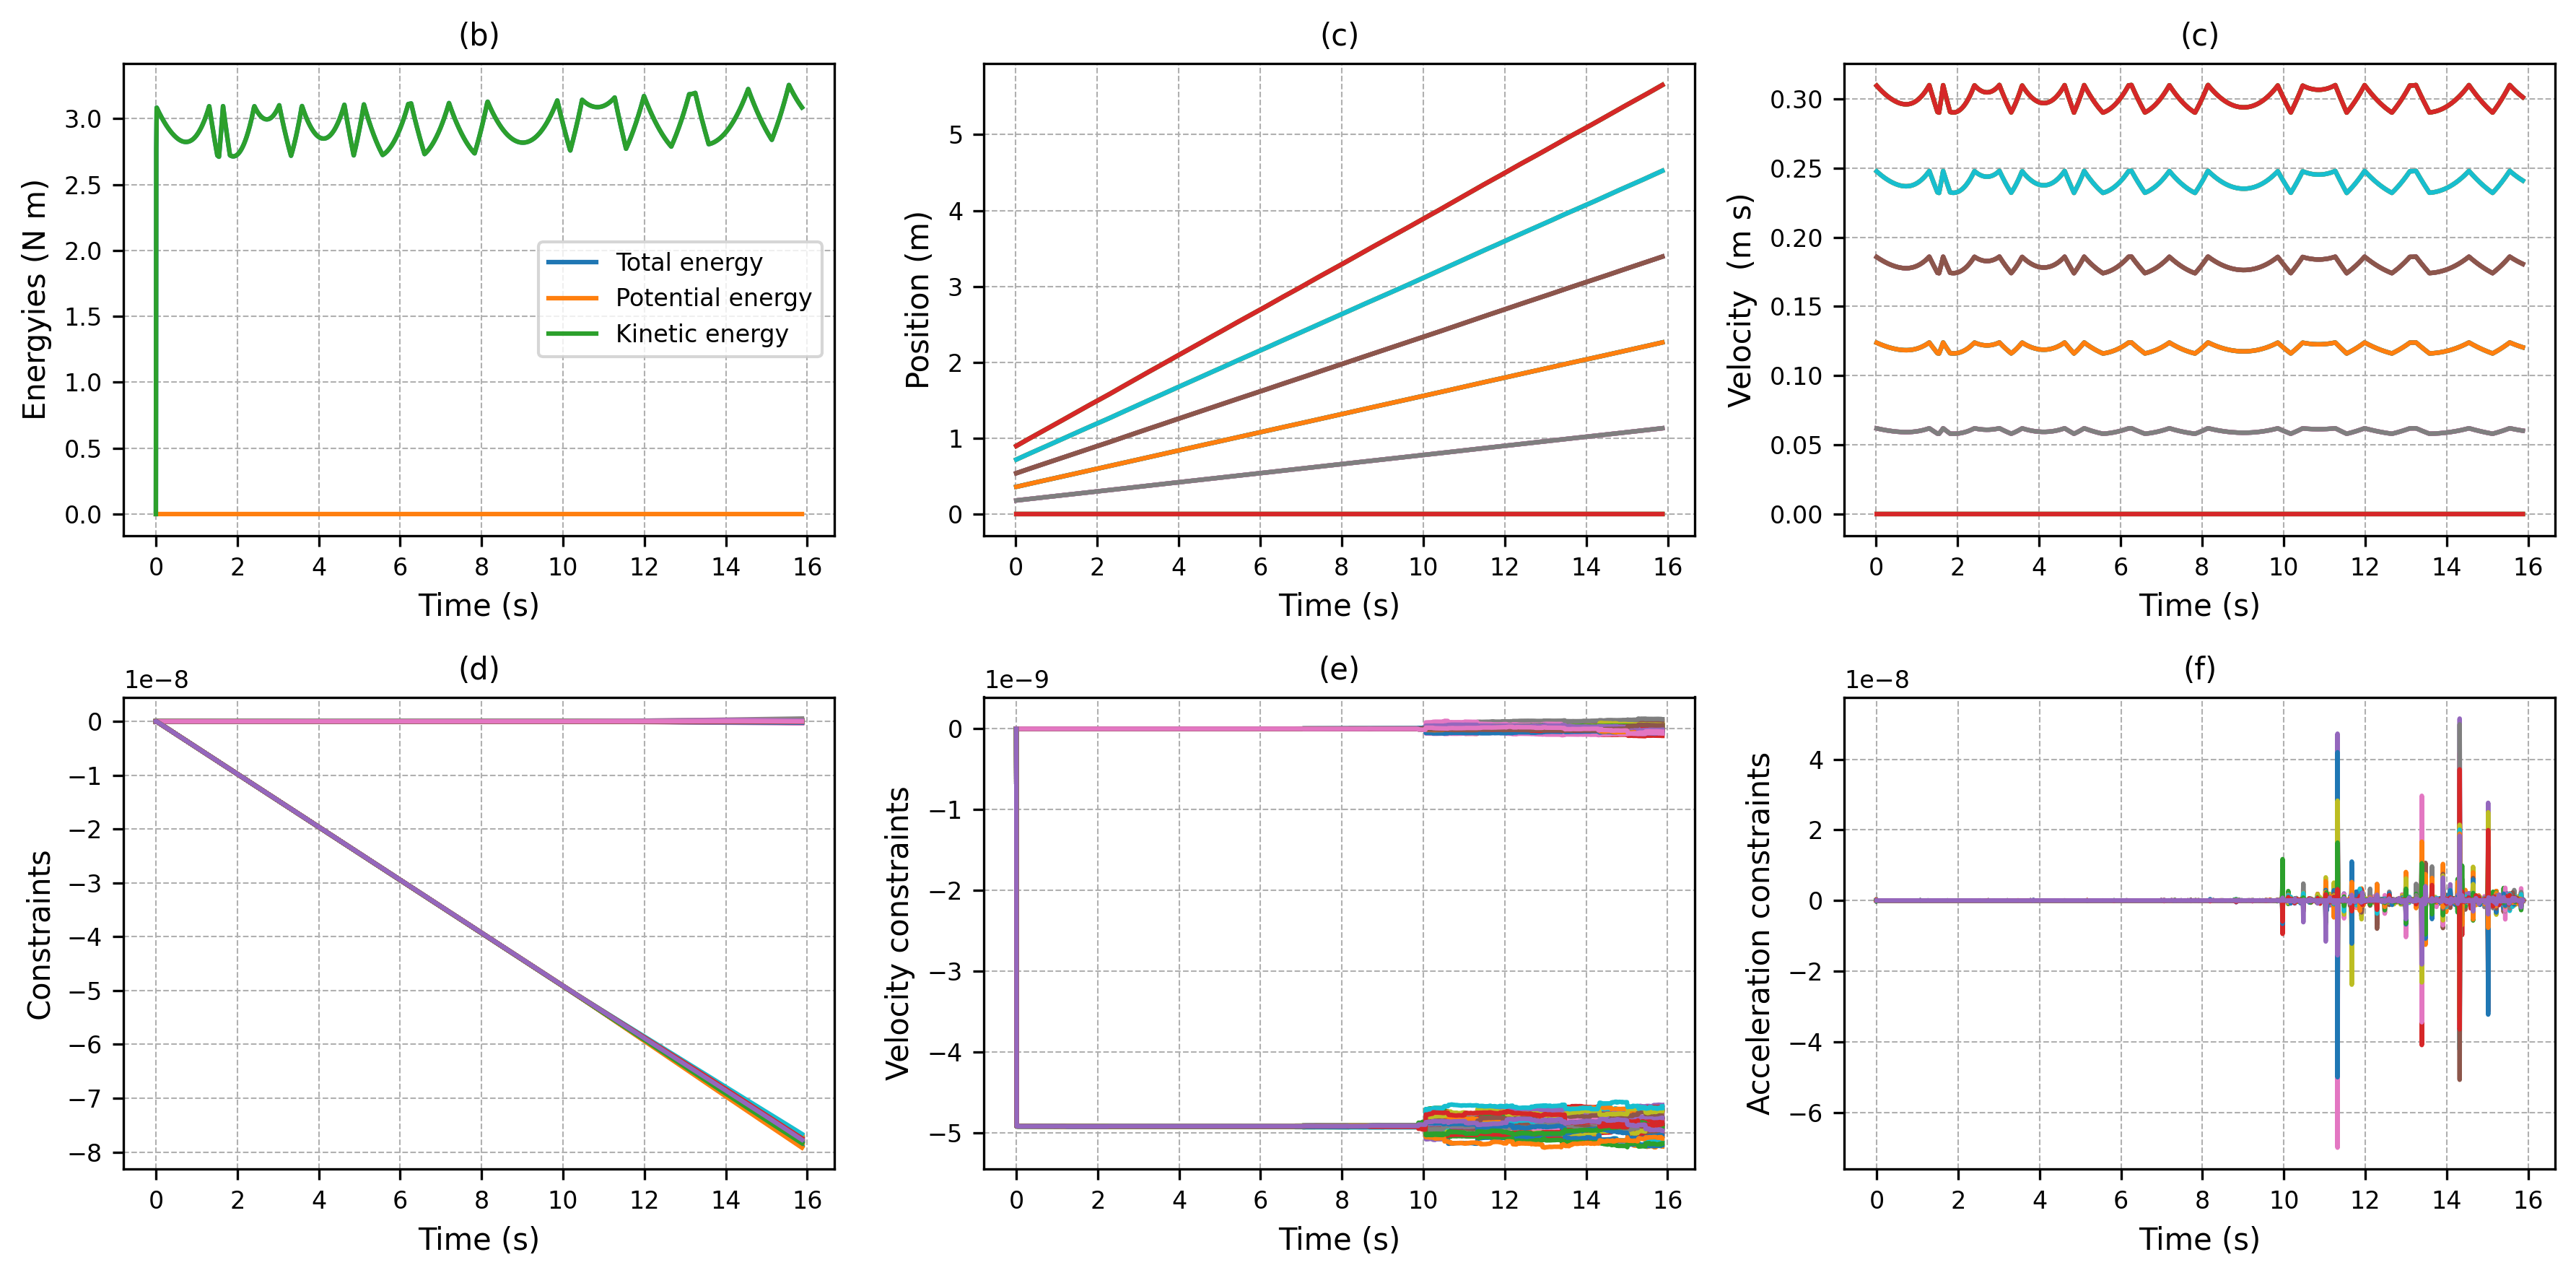

In [9]:
# fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=DPI)
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=Latex_DPI)

subfig = axs[0, 0]
subfig.set_title('(b)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Energyies (N m)')
subfig.plot(data_t, energy, label='Total energy')
subfig.plot(data_t, potential, label='Potential energy')
subfig.plot(data_t, kinetic, label='Kinetic energy')
subfig.legend()

subfig = axs[0, 1]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Position (m)')
# subfig.plot(data_t, q_hat[:,-1], label='Top point of the structure')
subfig.plot(data_t[2:], q_hat[2:,2::3])
# subfig.legend()

subfig = axs[0, 2]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity  (m s)')
subfig.plot(data_t[2:], qt_hat[2:,2::3])
# subfig.legend()

subfig = axs[1, 0]
subfig.set_title('(d)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Constraints')
subfig.plot(data_t, phi[:, :])

subfig = axs[1, 1]
subfig.set_title('(e)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity constraints')
subfig.plot(data_t, phi_t[:, :])

subfig = axs[1, 2]
subfig.set_title('(f)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Acceleration constraints')
subfig.plot(data_t, phi_tt[:, :])

plt.tight_layout()

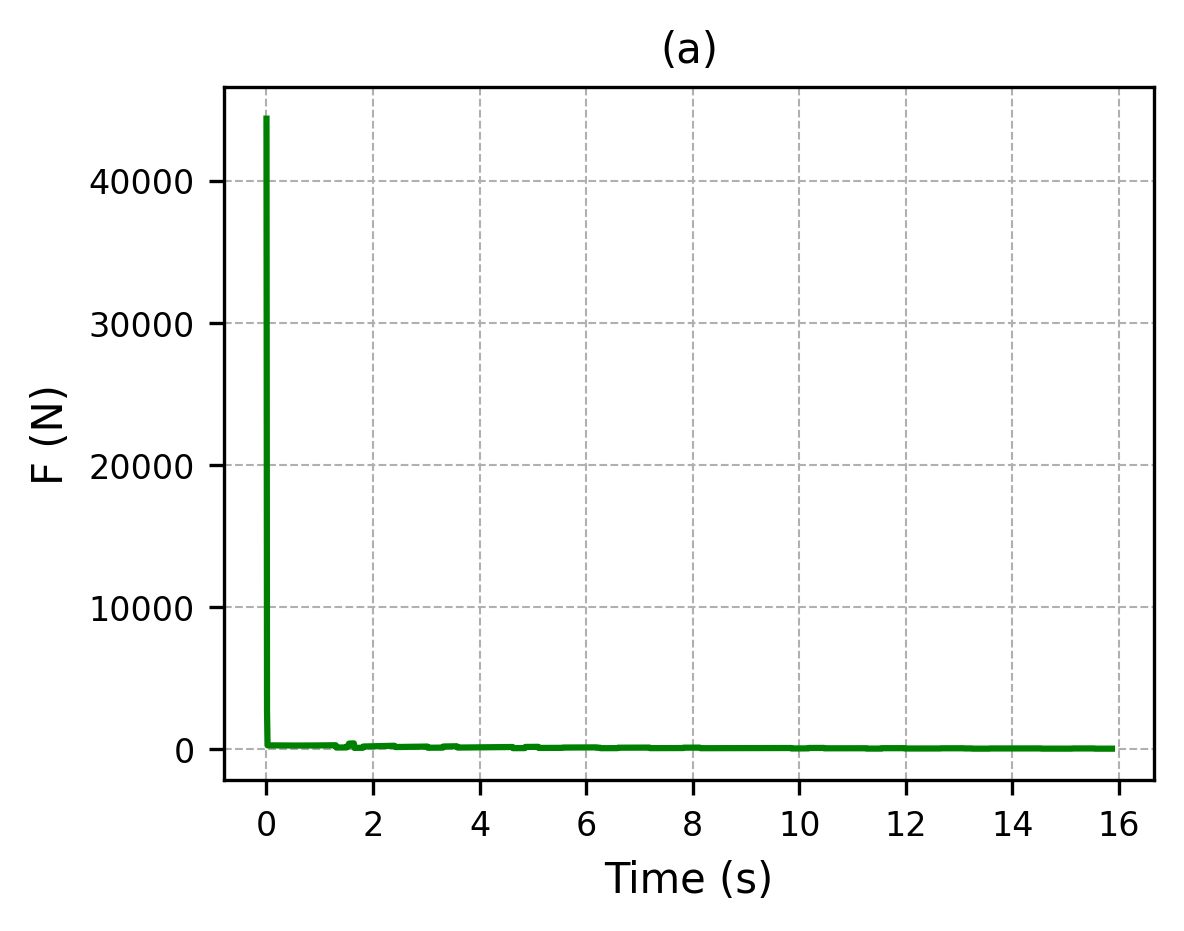

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(4 * 1, 3 * 1), dpi=Latex_DPI)

subfig = axs
subfig.set_title('(a)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('F (N)')
subfig.plot(data_t, F_list, 'g-')

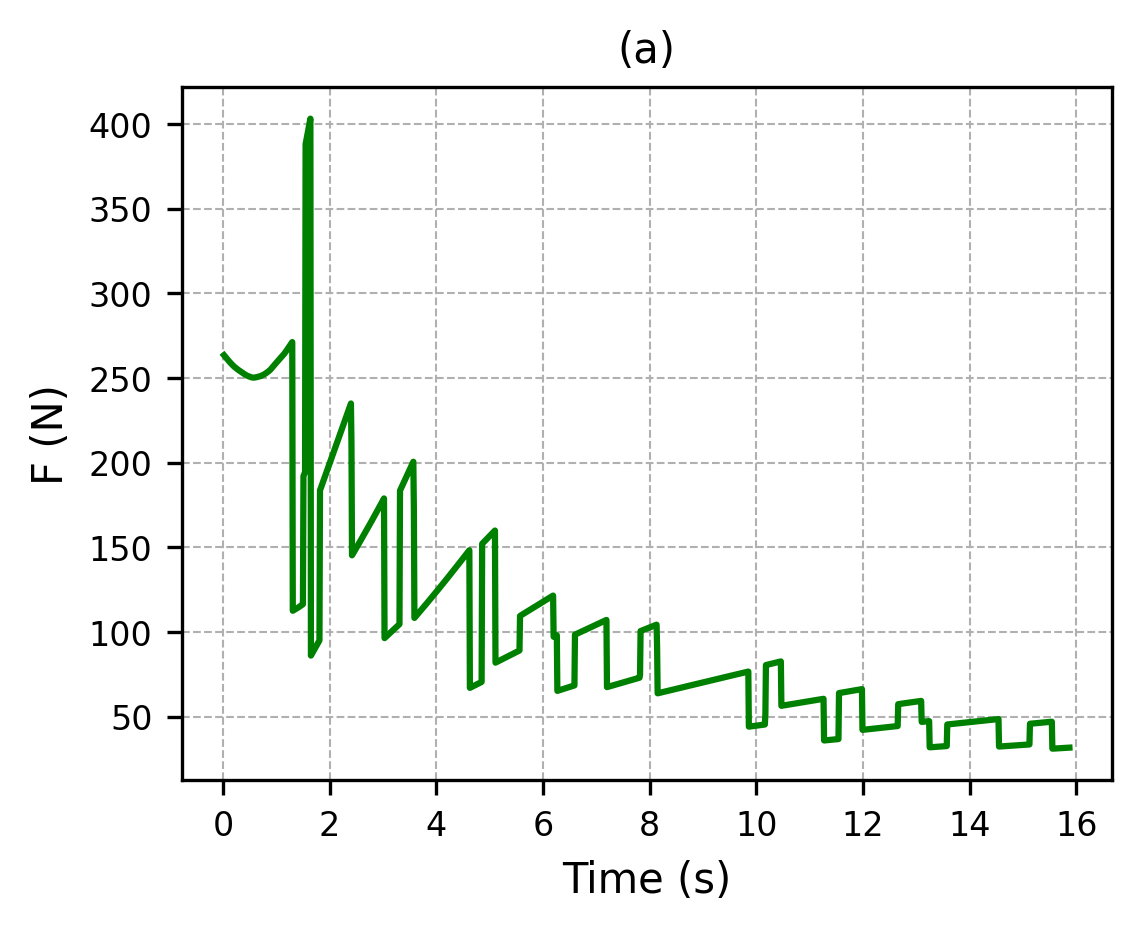

In [11]:
# plot_F_data_t = data_t[:-1]

fig, axs = plt.subplots(1, 1, figsize=(4 * 1, 3 * 1), dpi=Latex_DPI)

subfig = axs
subfig.set_title('(a)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('F (N)')
subfig.plot(data_t[2:], F_list[2:], 'g-')

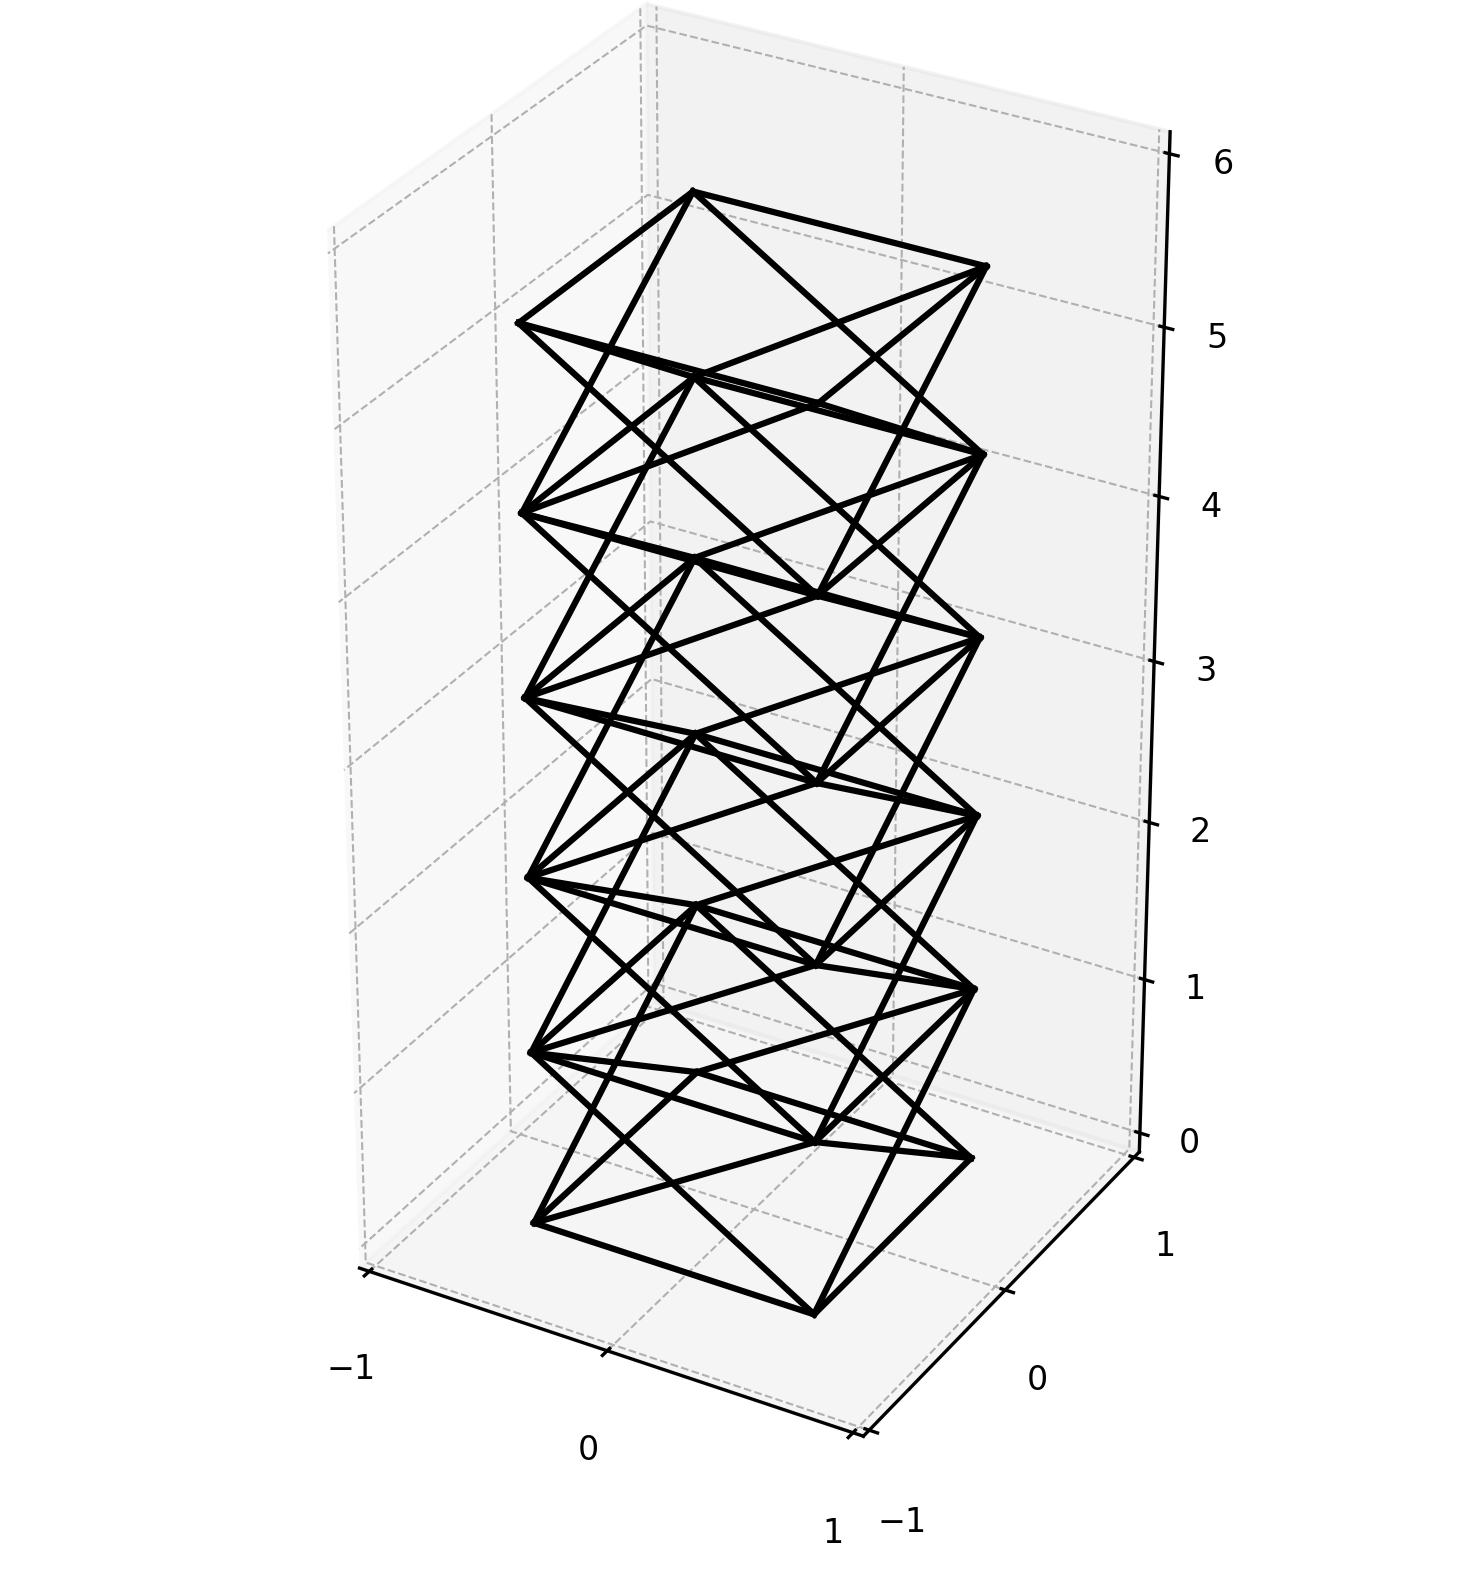

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# 设置参数
fps = 30  # 帧率
duration = len(data_t[2:]) # 动画持续时间（秒）
num_frames = int(duration / fps) # 帧数

# 创建动画
fig = plt.figure(figsize=(5, 10), dpi=Latex_DPI)
ax = plt.subplot(1, 1, 1, projection='3d')
subfig = ax
subfig.set_title('Animation')
subfig.set_xlabel('Position (m)')
subfig.set_ylabel('Position (m)')
plt.tight_layout()

q = q_hat
qt = qt_hat
def animate(frame):
    subfig.clear()

    time = int(frame * fps)

    subfig.plot([q[time, 0], q[time, 3]], [q[time, 1], q[time, 4]], [q[time, 2], q[time, 5]], 'k-')  # 12
    subfig.plot([q[time, 3], q[time, 6]], [q[time, 4], q[time, 7]], [q[time, 5], q[time, 8]], 'k-')  # 23
    subfig.plot([q[time, 6], q[time, 9]], [q[time, 7], q[time, 10]], [q[time, 8], q[time, 11]], 'k-')  # 34
    subfig.plot([q[time, 0], q[time, 9]], [q[time, 1], q[time, 10]], [q[time, 2], q[time, 11]], 'k-')  # 14

    for k in range(1, 6):
        subfig.plot([q[time, 12 * k], q[time, 12 * k + 3]],
                 [q[time, 12 * k + 1], q[time, 12 * k + 4]],
                 [q[time, 12 * k + 2], q[time, 12 * k + 5]], 'k-')  # 56
        subfig.plot([q[time, 12 * k + 3], q[time, 12 * k + 6]],
                 [q[time, 12 * k + 4], q[time, 12 * k + 7]],
                 [q[time, 12 * k + 5], q[time, 12 * k + 8]], 'k-')  # 67
        subfig.plot([q[time, 12 * k + 6], q[time, 12 * k + 9]],
                 [q[time, 12 * k + 7], q[time, 12 * k + 10]],
                 [q[time, 12 * k + 5], q[time, 12 * k + 11]], 'k-')  # 78
        subfig.plot([q[time, 12 * k + 0], q[time, 12 * k + 9]],
                 [q[time, 12 * k + 1], q[time, 12 * k + 10]],
                 [q[time, 12 * k + 2], q[time, 12 * k + 11]], 'k-')  # 58
        subfig.plot([q[time, 12 * k - 12], q[time, 12 * k + 3]],
                 [q[time, 12 * k - 11], q[time, 12 * k + 4]],
                 [q[time, 12 * k - 10], q[time, 12 * k + 5]], 'k-')  # 16
        subfig.plot([q[time, 12 * k - 12], q[time, 12 * k + 9]],
                 [q[time, 12 * k - 11], q[time, 12 * k + 10]],
                 [q[time, 12 * k - 10], q[time, 12 * k + 11]], 'k-')  # 18
        subfig.plot([q[time, 12 * k], q[time, 12 * k - 9]],
                 [q[time, 12 * k + 1], q[time, 12 * k - 8]],
                 [q[time, 12 * k + 2], q[time, 12 * k - 7]], 'k-')  # 25
        subfig.plot([q[time, 12 * k - 9], q[time, 12 * k + 6]],
                 [q[time, 12 * k - 8], q[time, 12 * k + 7]],
                 [q[time, 12 * k - 7], q[time, 12 * k + 8]], 'k-')  # 27
        subfig.plot([q[time, 12 * k - 6], q[time, 12 * k + 3]],
                 [q[time, 12 * k - 5], q[time, 12 * k + 4]],
                 [q[time, 12 * k - 4], q[time, 12 * k + 5]], 'k-')  # 36
        subfig.plot([q[time, 12 * k - 6], q[time, 12 * k + 9]],
                 [q[time, 12 * k - 5], q[time, 12 * k + 10]],
                 [q[time, 12 * k - 4], q[time, 12 * k + 11]], 'k-')  # 38
        subfig.plot([q[time, 12 * k + 0], q[time, 12 * k - 3]],
                 [q[time, 12 * k + 1], q[time, 12 * k - 2]],
                 [q[time, 12 * k + 2], q[time, 12 * k - 1]], 'k-')  # 45
        subfig.plot([q[time, 12 * k + 6], q[time, 12 * k - 3]],
                 [q[time, 12 * k + 7], q[time, 12 * k - 2]],
                 [q[time, 12 * k + 8], q[time, 12 * k - 1]], 'k-')  # 47
    
    subfig.set_box_aspect([1, 1, 2])  # 调整Z轴的刻度距离图像
    subfig.set_xticks([-1, 0, 1])
    subfig.set_yticks([-1, 0, 1])
    subfig.set_zticks([0, 1, 2, 3, 4, 5, 6])
    return []


ani = FuncAnimation(fig, animate, frames=num_frames, blit=True)

# # 保存为GIF文件
path = os.path.join(output_dir, 'animation.gif')
ani.save(path, writer='pillow')

In [13]:
##################################################################
#
# Prepare for next step of visualization
#
##################################################################

# print(q.shape)
# np.savetxt('results/optimize', q, delimiter=' ', newline='\n', fmt='%f')